In [229]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [230]:
filename = 'data/cleaned_data.csv'
df = pd.read_csv(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   from_encounter             50401 non-null  int64  
 1   fishing_vessel_mmsi        10126 non-null  float64
 2   transshipment_vessel_mmsi  50401 non-null  int64  
 3   start_time                 50401 non-null  object 
 4   end_time                   50401 non-null  object 
 5   mean_latitude              50401 non-null  float64
 6   mean_longitude             50401 non-null  float64
 7   duration_hr                50401 non-null  float64
 8   median_distance_km         10126 non-null  float64
 9   median_speed_knots         50401 non-null  float64
 10  starting_timestamp         50401 non-null  float64
 11  ending_timestamp           50401 non-null  float64
 12  mmsi_t                     50401 non-null  float64
 13  shipname_t                 50401 non-null  obj

First we are taking a look at the correlation matrix

<AxesSubplot:>

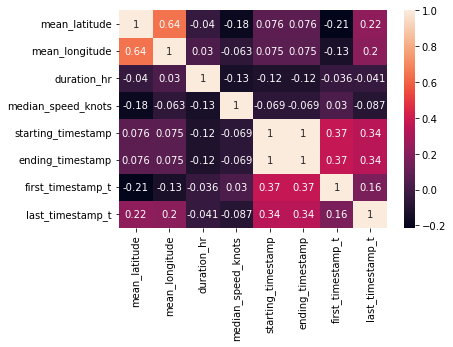

In [240]:
KMeans_input_columns = ['mean_latitude', 'mean_longitude', 'duration_hr', 'median_speed_knots','starting_timestamp', 'ending_timestamp', 'first_timestamp_t', 'last_timestamp_t'] # only select numerical features

sns.heatmap(df[KMeans_input_columns].corr(), annot=True)

We can observe that we have high correlations between
-mean_latitude and mean_longitude
-starting_timestamp and ending_timestamp

Some preprocessing is necessary:

In [231]:
KMeans_input_columns = ['mean_latitude', 'mean_longitude', 'duration_hr', 'median_speed_knots','starting_timestamp', 'ending_timestamp', 'first_timestamp_t', 'last_timestamp_t']

scaler = StandardScaler()  # z-score standardization
standardized_df = pd.DataFrame(scaler.fit_transform(df[KMeans_input_columns]))  # standardize columns to have mean=0 and std=1 (+/- numerical errors)
standardized_df.rename(columns=dict(zip(list(standardized_df.columns),KMeans_input_columns)), inplace=True)  # column names are lost during standardization

Now we are ready to apply the k_Means alg on the data

In [233]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=False).fit_predict(standardized_df)

In [234]:
standardized_df['Cluster'] = pd.DataFrame(kmeans)  # add cluster column

standardized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_latitude       50401 non-null  float64
 1   mean_longitude      50401 non-null  float64
 2   duration_hr         50401 non-null  float64
 3   median_speed_knots  50401 non-null  float64
 4   starting_timestamp  50401 non-null  float64
 5   ending_timestamp    50401 non-null  float64
 6   first_timestamp_t   50401 non-null  float64
 7   last_timestamp_t    50401 non-null  float64
 8   Cluster             50401 non-null  int32  
dtypes: float64(8), int32(1)
memory usage: 3.3 MB


In [235]:
pca = PCA(n_components=2)
pca.fit(standardized_df[KMeans_input_columns])
projected_data = pd.DataFrame(pca.transform(standardized_df[KMeans_input_columns]))
projected_data.rename(columns={0:'first_PC', 1: 'second_PC'}, inplace=True)

Now we are going to project the data onto the first principal components

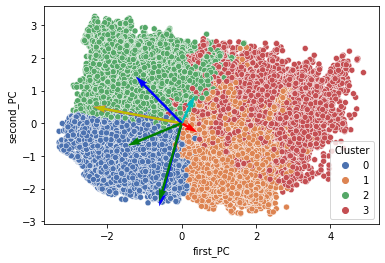

In [236]:
#plt.scatter(projected_data[:,0],projected_data[:,1])
origin = np.zeros_like(pca.components_)

sns.scatterplot(x=projected_data['first_PC'],y=projected_data['second_PC'], hue=standardized_df['Cluster'], palette="deep")
plt.quiver(*origin, pca.components_[0], pca.components_[1],angles='xy', scale=0.25,scale_units='xy', color=('b','g','r','c','m','y'))

In [237]:
print('Explained variance by first principal: {:.1f} % \nExplained variance by second principal: {:.1f} % \nTotal: {:.1f} %'
      .format(pca.explained_variance_ratio_[0]*100, pca.explained_variance_ratio_[1]*100,
              pca.explained_variance_ratio_[0]*100 + pca.explained_variance_ratio_[1]*100 ))

Explained variance by first principal: 30.9 % 
Explained variance by second principal: 22.6 % 
Total: 53.5 %


In [238]:
print(pca.components_)

[[-0.15100806 -0.15125494  0.10511684  0.08692989 -0.59578425 -0.59572059
  -0.30799559 -0.36195161]
 [-0.6358083  -0.59952898 -0.0690308   0.20957759  0.1252207   0.12512639
   0.35702207 -0.16977394]]


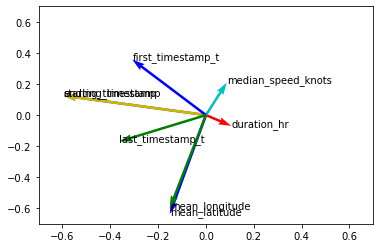

In [239]:
origin = np.zeros_like(pca.components_)
plt.xlim([-0.7,0.7])
plt.ylim([-0.7,0.7])

# plt.scatter(x=pca.components_[0],y=pca.components_[1])
plt.quiver(*origin, pca.components_[0], pca.components_[1],angles='xy', scale=1,scale_units='xy', color=('b','g','r','c','m','y'))
#plt.legend(title='Feature', loc='upper right')
for i, txt in enumerate(KMeans_input_columns):
    plt.annotate(txt, (pca.components_[0][i],pca.components_[1][i]))